In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 697 (delta 69), reused 65 (delta 34), pack-reused 591 (from 1)
Receiving objects: 100% (697/697), 978.10 KiB | 3.98 MiB/s, done.
Resolving deltas: 100% (451/451), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.read_datasets import read_sipgate_dataset
from bin.utils.clean_sipgate_dataset import clean_sipgate_dataset
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [6]:
def results_to_dataframe(results: list[dict]):
    # Initialize an empty DataFrame
    columns = ["intent"] + list(list(results[0].values())[0]["results"].keys())
    df = pd.DataFrame(columns=columns)
    df.set_index("intent", inplace=True)

    # Process each intent dictionary
    for intent_dict in results:
        for intent_name, data in intent_dict.items():
            results = data["results"]
            df.loc[intent_name] = results

    df["intent"] = df.index
    df.reset_index(drop=True, inplace=True)

    return df

In [24]:
def plot_results_df(df: pd.DataFrame, plot_func=plt.hist, **kwargs):
    # make a dashboard of plots
    # where each plot is the distribution of a metric
    # across all intents
    n_metrics = len([col for col in df.columns if not df[col].isnull().all()]) - 1
    n_cols = 2
    n_rows = -(-n_metrics // n_cols)  # Ceiling division

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axs = axs.flatten()

    for i, metric in enumerate(df.columns[1:]):
        if metric == "intent" or df[metric].isnull().all():
            continue

        x, y = df[metric].index, df[metric].values

        ax = axs[i]
        sns.stripplot(
          data=df,
          x=metric,
          ax=ax,
          color="blue",
          alpha=0.5,
          linewidth=0,
        )
        ax.set_title(metric)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")

        # if there is a df_2 in kwargs, overlay it
        if "df_2" in kwargs:
          df_2 = kwargs["df_2"]
          sns.stripplot(
              data=df_2,
              x=metric,
              ax=ax,
              color="red",
              alpha=0.5,
              linewidth=0,
          )

    plt.tight_layout()
    plt.show()

In [11]:
dataset_name = "persona_based_prompt_s1_data"
gen_df = pd.read_csv(f"data/{dataset_name}.csv", encoding="utf-8")
gen_df.rename(columns={"query": "text"}, inplace=True)
# remove rows with invalid values in text column
gen_df = gen_df[gen_df["text"].apply(lambda x: isinstance(x, str))]
ref_df = clean_sipgate_dataset(read_sipgate_dataset())

In [ ]:
framework = Framework()
results = framework.apply_framework_to_datasets(gen_df, ref_df)
df = results_to_dataframe(results)
plot_results_df(df)

In [16]:
dataset_name = "chain_of_thought_simple_data"
gen_df_2 = pd.read_csv(f"data/{dataset_name}.csv", encoding="utf-8")
gen_df_2.rename(columns={"query": "text"}, inplace=True)
# remove rows with invalid values in text column
gen_df_2 = gen_df[gen_df_2["text"].apply(lambda x: isinstance(x, str))]

<ipython-input-16-9c8eb9f39246>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen_df_2 = gen_df[gen_df_2["text"].apply(lambda x: isinstance(x, str))]


In [ ]:
results_2 = framework.apply_framework_to_datasets(gen_df, ref_df)
df_2 = results_to_dataframe(results)

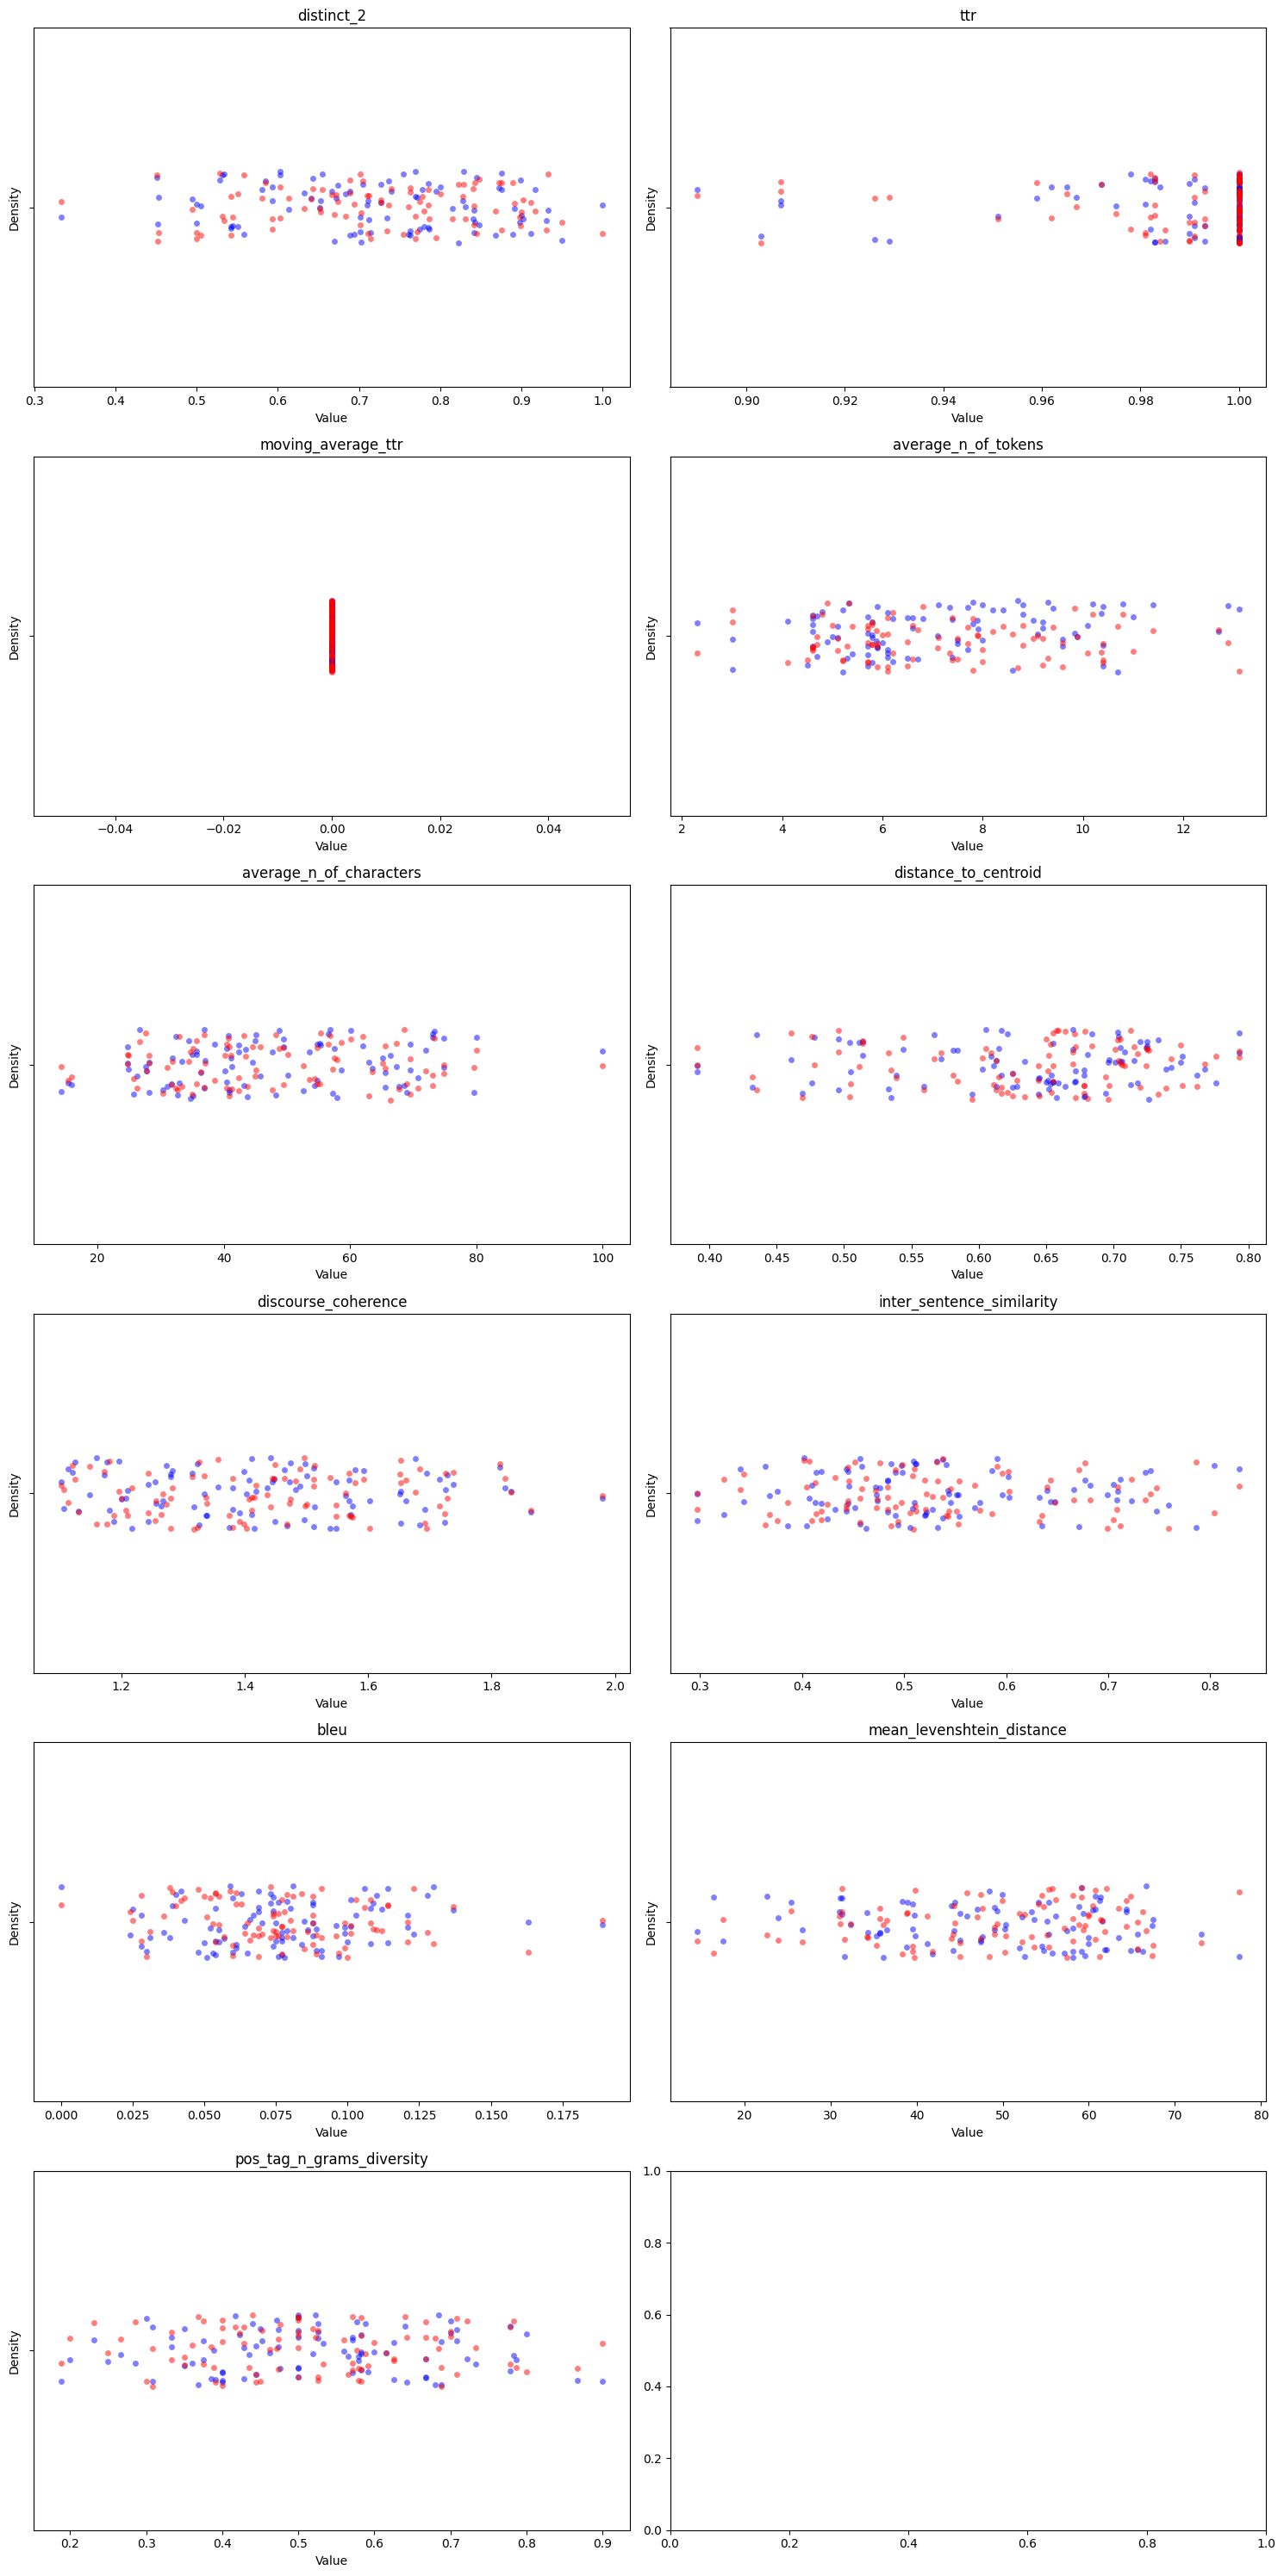

In [25]:
plot_results_df(df, df_2=df_2)